In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from collections import OrderedDict
from IPython.display import display

import ipyparallel as ipp
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import itertools

import MESS
from MESS.util import set_params

## Set some pandas options to show the full rows and columns of a DF
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', 1000)

## Where do you want the simulation output to life?
analysis_dir = "/home/iovercast/Continuosity/MESS/analysis/"
analysis_dir = analysis_dir + "/full-parameter-estimation/"
if not os.path.exists(analysis_dir):
    os.mkdir(analysis_dir)

In [19]:
ipyclient = ipp.Client(cluster_id="MESS-Rich")
print(len(ipyclient))

40


In [32]:
r = MESS.Region("whole_enchilada")
## Region params
r.set_param("project_dir", analysis_dir)
r.set_param("generations", 0)
r.set_param("community_assembly_model", "*")
r.set_param("mutation_rate", 2.2e-8)
r.set_param("alpha", (500, 5000))

## Metacommunity Params
r.set_param("S_m", 500)
r.set_param("J_m", (5e4, 5e6))
r.set_param("speciation_rate", 2)
r.set_param("death_proportion", 0.7)
r.set_param("trait_rate_meta", 2)
r.set_param("ecological_strength", (1, 10))

## Local Params
r.set_param("J", 1000)
r.set_param("m", (0.001, 0.01))
r.set_param("speciation_prob", (0.0001, 0.001))

r.write_params(full=True, force=True)
#r.run(sims=1000, ipyclient=ipyclient)

5985


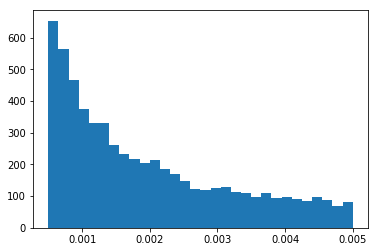

In [47]:

analysis_dir = "/home/iovercast/Continuosity/MESS/analysis/figure5-sims/"
sim_file = analysis_dir + "fig5_sims/SIMOUT.txt"

sim_df = pd.read_csv(sim_file, sep="\t", header=0)
_, _, _ = plt.hist(sim_df["speciation_prob"], bins=30)
print(len(sim_df))

## An example of how to perform CV prediction and plot the results

Removed invariant targets. Retained: ['alpha', 'ecological_strength', 'J', 'm', 'generation', 'speciation_prob', '_lambda']

Estimator has not been optimized prior to CV. Performing estimator CV skipping
feature selection and hyperparameter optimization. For better performance call
predict() on the estimator prior to calling the cv_predict/cv_score methods.

MAE:
alpha                  2701.881549
ecological_strength       0.169690
J                      2789.218169
m                         0.002198
generation              369.544789
speciation_prob           0.001194
_lambda                   0.294184
Name: MAE, dtype: float64
RMSE:
alpha                  72.708349
ecological_strength     0.005125
J                      74.079967
m                       0.000060
generation             11.919657
speciation_prob         0.000033
_lambda                 0.007808
Name: RMSE, dtype: float64
vscores:
alpha                  0.566083
ecological_strength   -0.103688
J                      0.7

array([<matplotlib.axes._subplots.AxesSubplot object at 0x2aaaef2b8190>,
      dtype=object)

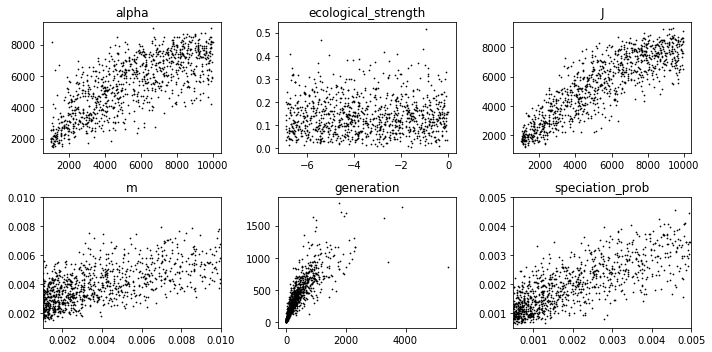

In [48]:

## Ensemble class needs to be fed a df for the empirical data
## which is ignored by the cv routines, so here we just give
## it some dummy data.
tmp_com = MESS.util.synthetic_community()

neut_rgr = MESS.inference.Regressor(tmp_com, sim_file, target_model="neutral", algorithm="rf", verbose=True)

neut_rgr.cross_val_predict(quick=True, verbose=True)

neut_rgr.plot_cv_predictions()

In [29]:
feature_sets = MESS.stats.feature_sets()
for i, (f, features) in enumerate(feature_sets.items()):
    print(i, f, len(features))

(0, 'abundance', 5)
(1, 'pi', 20)
(2, 'dxy', 6)
(3, 'trait', 10)
(4, 'abundance+pi', 26)
(5, 'pi+dxy', 27)
(6, 'pi+trait', 31)
(7, 'abundance+trait', 16)
(8, 'abundance+pi+trait', 38)
(9, 'all', 48)


## Run CV prediction for all assembly models and all supported ensemble methods
This will take a while.

In [52]:
cv_dir = analysis_dir + "cv_results/"
if not os.path.exists(cv_dir):
    os.mkdir(cv_dir)

quick=False
verbose=False

for algorithm in ["ab", "gb", "rf"]:
    for model in ["neutral", "filtering", "competition"]:
        !date
        print(algorithm, model)
        outdir = cv_dir + algorithm + "/"
        if not os.path.exists(outdir):
            os.mkdir(outdir)
        rgr = MESS.inference.Regressor(tmp_com, sim_file, target_model=model, algorithm=algorithm, verbose=verbose)
        _ = rgr.cross_val_predict(quick=quick, verbose=verbose)
        rgr.dump(outfile=outdir + model + ".mdl")
        _ = rgr.plot_cv_predictions(outfile=outdir + model + "-cv.png")
        rgr.cv_stats.to_csv(outdir + model + "-stats.csv")
        display(rgr.cv_stats)



Tue Jun  4 17:21:06 EDT 2019
('ab', 'neutral')


AttributeError: 'Regressor' object has no attribute 'best_model'

In [46]:
outdir = os.path.join(cv_dir + algorithm)
outdir

'/home/iovercast/Continuosity/MESS/analysis/figure5-sims/cv_results/rfq'